In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib as mpl
import networkx as nx
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.animation import FuncAnimation
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib import rc
rc('animation', html='jshtml')

import pdb

def createFilename(prop):
    return 'sim_' + '_'.join([f'{x}={prop[x]}' for x in prop])

In [77]:
def step(x, nsize):
    """Makes one step in the cellular automaton.
    Args:
        x (np.array): current state of the automaton
        rule_binary (np.array): the update rule
    Returns:
        np.array: updated state of the automaton
    """
    
    h = x.h
    sigma = np.zeros_like(h)
    mu = np.zeros_like(h)
    for i in range(h.shape[0]):
        for j in range(h.shape[1]):
            xmin = max(0, i - nsize)
            xmax = min(h.shape[0], i + 1 + nsize)
            ymin = max(0, j - nsize)
            ymax = min(h.shape[1], j + 1 + nsize)
            N = h[xmin:xmax, ymin:ymax]
            sigma[i,j] = N.std()
            mu[i,j] = N.mean()
    
    d = np.random.randn(*h.shape) * np.sqrt(sigma)
    xn = mu + d
    return xn

def cellular_automaton(size, steps, nsize = 1,
                       init_cond='random', impulse_pos='center'):
    """Generate the state of an elementary cellular automaton after a pre-determined
    number of steps starting from some random state.
    Args:
        rule_number (int): the number of the update rule to use
        size (int): number of cells in the row
        steps (int): number of steps to evolve the automaton
        init_cond (str): either `random` or `impulse`. If `random` every cell
        in the row is activated with prob. 0.5. If `impulse` only one cell
        is activated.
        impulse_pos (str): if `init_cond` is `impulse`, activate the
        left-most, central or right-most cell.
    Returns:
        np.array: final state of the automaton
    """
    assert init_cond in ['random', 'impulse', 'zero']
    assert impulse_pos in ['left', 'center', 'right']
    assert nsize < size 
    
    x = xr.Dataset(
            data_vars=dict(
                h =(["step", "x", "y"], np.zeros((steps, size, size))),
                d =(["step", "x", "y"], np.zeros((steps, size, size))),
            ),
            coords=dict(
                step=np.arange(steps),
                x = np.arange(size),
                y = np.arange(size),
            ),
            attrs=dict(description="Simulated data",
                       model_type = "Model 1: No spatial dependency"),
        )
    
    
    if init_cond == 'random':  # random init of the first step
        x.h[0, :, :] = np.array(np.random.rand(size, size) < 0.5, dtype=np.int8)

    if init_cond == 'impulse':  # starting with an initial impulse
        if impulse_pos == 'left':
            x.h[0, 0, 0] = 1
        elif impulse_pos == 'right':
            x.h[0, size - 1, 0] = 1
        else:
            x.h[0, size // 2, size // 2] = 1
    
    for i in range(steps - 1):
        x.h[i+1,:,:] = step(x[dict(step = i)], nsize)
    
    return x


prop = dict(size = 20, 
            steps = 200, 
            nsize = 1, 
            init_cond = 'impulse', 
            impulse_pos = 'right'
           )

ca = cellular_automaton(**prop)

def createFilename(prop):
    return 'sim_' + '_'.join([f'{x}={prop[x]}' for x in prop])

path = './simulation/'
filename = createFilename(prop)
ca.to_netcdf(path + filename + '.nc')
print('saved simulation')


saved simulation


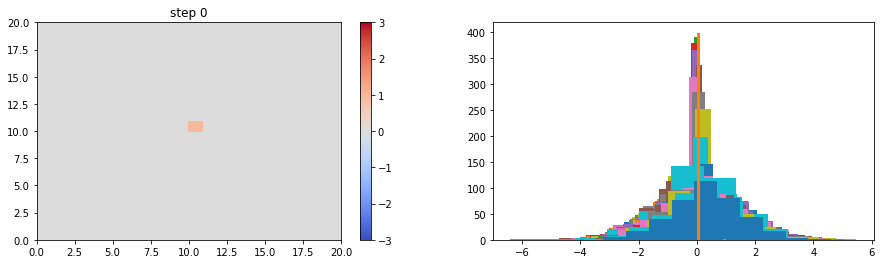

In [7]:
cmap = cm.get_cmap('coolwarm')
norm = colors.Normalize(vmin=-3, vmax=3)

prop = dict(size = 20, 
            steps = 100, 
            nsize = 1, 
            init_cond = 'impulse', 
            impulse_pos = 'center'
           )

path = './simulation/'
filename = createFilename(prop)
ca = xr.open_dataset(path + filename + '.nc')

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

def animate(i):
    ax.clear()
    ax.set_title('step ' + str(i))
    plot = ax.pcolor(ca.h[i,:,:], cmap = cmap, norm = norm)
    ax2.hist(ca.h[i,:,:].data.flatten())
#     cb = fig.colorbar(plot, ax = ax)
    return plot

# Create animation
ani = FuncAnimation(fig=fig, func=animate, frames=range(len(ca.step)), interval=500, repeat=True)

ani

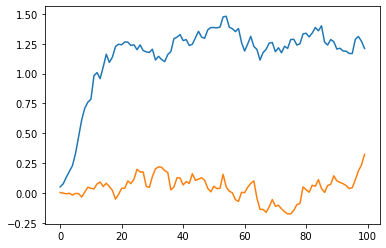

In [5]:
t = ca.step
y = np.array([ca.h[i,:,:].std() for i in np.arange(len(t)) ])
m = np.array([ca.h[i,:,:].mean() for i in np.arange(len(t)) ])
plt.plot(t, y)
plt.plot(t,m)

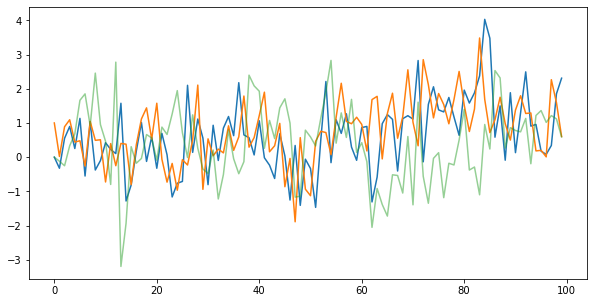

In [58]:
t = ca.step
p = np.array([ca.h[i,0,17] for i in np.arange(len(t)) ])
q = np.array([ca.h[i,1,17] for i in np.arange(len(t)) ])
r = np.array([ca.h[i,10,0] for i in np.arange(len(t)) ])
plt.figure(figsize = (10,5))
plt.plot(t, p, t, q)
plt.plot(t,r, alpha = .5)


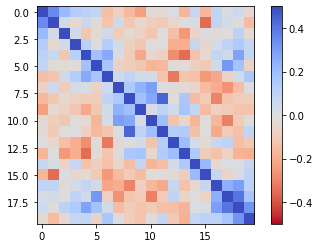

In [73]:
cmap = cm.get_cmap('coolwarm')
norm = colors.Normalize(vmin=-.5, vmax=.5)
plt.imshow(np.corrcoef(ca.h[10:,:,10].T), cmap = 'coolwarm_r', norm = norm)
plt.colorbar()

In [53]:
np.random.rand(5,5)

array([[0.96199779, 0.33353833, 0.75284478, 0.62618176, 0.04416851],
       [0.18413842, 0.32994845, 0.22255984, 0.01510887, 0.93456301],
       [0.48946219, 0.86153029, 0.04026256, 0.09937646, 0.10184083],
       [0.97587867, 0.35273898, 0.85711176, 0.01349215, 0.6297902 ],
       [0.9399926 , 0.12124279, 0.6826575 , 0.85847661, 0.19563565]])


np.random.rand(size)